In [1]:
from math import pi
import matplotlib.pyplot as plt
from pennylane import numpy as np
import pennylane as qml
from pennylane.optimize import AdamOptimizer
import datetime
now=datetime.datetime.now

## Generate data

$f(x_1,x_2)=0.5\sin(\pi x)\sin(\pi x_2)+0.8\cos^2(\pi x_1)+0.3\sin(\pi x_2)$

In [2]:
coef=pi
def my_objective(X):
    Y=0.5*np.sin(coef*X[:,0])*np.sin(coef*X[:,1])+0.8*np.cos(coef*X[:,0])**2+0.3*np.sin(coef*X[:,1])
    return Y

In [3]:
np.random.seed(0)
X=np.random.uniform(-0.95,0.95,size=(100,2),requires_grad=False)

In [4]:
Y=my_objective(X)

In [5]:
print(X.shape)
print(Y.shape)

(100, 2)
(100,)


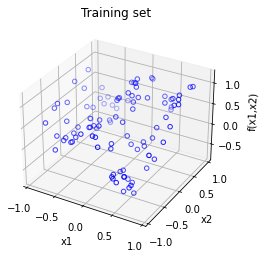

In [6]:
# plot data
fig = plt.figure()
ax=plt.axes(projection='3d')
ax.scatter(X[:,0],X[:,1],Y,facecolors='none', edgecolors='b')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('f(x1,x2)')
plt.title('Training set')
plt.savefig('2_non_square_target.png')
plt.show()

## Set Device

In [7]:
num_qubits=3
dev=qml.device('default.qubit', wires=num_qubits)

## Define embedding layer

In [8]:
# define my own embedding layer
def myembedding(x,wires):
    qml.RY(coef*x[0], wires=wires[1])
    qml.RY(coef*x[1], wires=wires[2])

## Define the Hamiltonian matrix transformation layer

In [9]:
def Ham():
    obs=[]
    for j in range(num_qubits):
        obs.append(qml.PauliX(j))
        for k in range(j):
            obs.append(qml.PauliZ(j)@qml.PauliZ(k))
    coeffs=np.random.uniform(-1,1,len(obs))*10
    qml.Hamiltonian(coeffs, obs)

## Define ansatze

In [10]:
# define ansastz layer
def layer(theta):
    
    # Apply Hamiltonian matrix
    Ham()
    
    # Apply H gate
    qml.Hadamard(0)
    
    # rotations on qubit 0
    qml.RX(theta[0,0],wires=0)
    qml.RZ(theta[0,1],wires=0)
    qml.RX(theta[0,2],wires=0)
    
    # rotations on qubit 1
    qml.RX(theta[1,0],wires=1)
    qml.RZ(theta[1,1],wires=1)
    qml.RX(theta[1,2],wires=1)
    
    # rotations on qubit 2
    qml.RX(theta[2,0],wires=2)
    qml.RZ(theta[2,1],wires=2)
    qml.RX(theta[2,2],wires=2)
    
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[0, 2])

In [11]:
@qml.qnode(dev)
def quantum_net(theta,x):
    
    # encode data
    myembedding(x,wires=range(num_qubits))
    
    # parameterized circuit layers
    for v in theta: # (for lool along with the first dimension)
        # print(v)
        # Ham()
        layer(v)
    
    qml.Hadamard(0)
    
    return qml.expval(qml.PauliZ(0)), qml.expval(qml.PauliZ(2))

In [12]:
num_layers=4
num_rotations=3
theta=np.random.uniform(0,2*pi,size=(num_layers,num_qubits,num_rotations),requires_grad=True)
print(theta.shape)
print(theta)

(4, 3, 3)
[[[1.9590713  4.37525518 2.37348481]
  [1.12848319 0.15506102 0.4225419 ]
  [4.26875069 2.85066135 3.37142662]]

 [[5.63395189 6.22248312 1.36280395]
  [4.16624322 1.65450329 0.12975406]
  [4.76503362 2.01072706 2.40937471]]

 [[3.69650544 5.22163144 3.95200948]
  [5.48302578 1.71871529 5.01427614]
  [1.16638504 5.98656654 4.31961624]]

 [[1.35407467 5.95250497 4.59210247]
  [1.5955624  1.34027868 3.25595111]
  [0.16124361 1.30357293 2.6683775 ]]]


In [13]:
quantum_net(theta,[0,0])

tensor([-0.0263888 , -0.06231091], requires_grad=True)

In [14]:
print(qml.draw(quantum_net)(theta,[0,0]))

0: ──H─────────RX(1.96)──RZ(4.38)──RX(2.37)─╭●────╭●──H─────────RX(5.63)──RZ(6.22)──RX(1.36)─╭●───
1: ──RY(0.00)──RX(1.13)──RZ(0.16)──RX(0.42)─╰X─╭●─│───RX(4.17)──RZ(1.65)──RX(0.13)───────────╰X─╭●
2: ──RY(0.00)──RX(4.27)──RZ(2.85)──RX(3.37)────╰X─╰X──RX(4.77)──RZ(2.01)──RX(2.41)──────────────╰X

──╭●──H─────────RX(3.70)──RZ(5.22)──RX(3.95)─╭●────╭●──H─────────RX(1.35)──RZ(5.95)──RX(4.59)─╭●───
──│───RX(5.48)──RZ(1.72)──RX(5.01)───────────╰X─╭●─│───RX(1.60)──RZ(1.34)──RX(3.26)───────────╰X─╭●
──╰X──RX(1.17)──RZ(5.99)──RX(4.32)──────────────╰X─╰X──RX(0.16)──RZ(1.30)──RX(2.67)──────────────╰X

──╭●──H─┤  <Z>
──│─────┤     
──╰X────┤  <Z>


## Add classical layer

In [15]:
# add the classical layer
def classical_quantum_net(theta,w,x):
    r1=quantum_net(theta,x)[0]
    r2=quantum_net(theta,x)[1]
    return w[0]+w[1]*r1+w[2]*r2

In [16]:
def square_loss(labels,predictions):
    loss=0
    for l,p in zip(labels,predictions):
        loss=loss+(l-p)**2
    loss=loss/len(labels)
    return loss

In [17]:
def cost(theta,w,features,labels):
    preds=[classical_quantum_net(theta,w,x) for x in features]
    return square_loss(labels,preds)

## Model training
Using the Adam optimizer, we update the weights for 200 steps (this takes some time). More steps will lead to a better fit.

In [18]:
w=np.zeros(3,requires_grad=True)
opt = AdamOptimizer(0.05, beta1=0.9, beta2=0.999)

In [19]:
start=now()
print(start)

2022-08-07 10:30:11.727891


In [20]:
epochs=200
for e in range(1,epochs+1):
    
    (theta,w,_,_),_cost=opt.step_and_cost(cost,theta,w,X,Y)

    if e==1 or e%10==0:
        print(f'Epoch: {e} | Cost: {_cost} | w: {w}')

Epoch: 1 | Cost: 0.34125220326158273 | w: [0.04999998 0.0499998  0.04999843]
Epoch: 10 | Cost: 0.10945901601813614 | w: [0.39014382 0.46641724 0.44961123]
Epoch: 20 | Cost: 0.07654568734930382 | w: [0.41302498 0.7010848  0.77432968]
Epoch: 30 | Cost: 0.0725170539060313 | w: [0.41813107 0.75958034 0.89045853]
Epoch: 40 | Cost: 0.0723556619691472 | w: [0.41334653 0.77258985 0.9268735 ]
Epoch: 50 | Cost: 0.07208052353594625 | w: [0.40855493 0.77472082 0.93636498]
Epoch: 60 | Cost: 0.07202516600856633 | w: [0.41134567 0.77068203 0.93884701]
Epoch: 70 | Cost: 0.07196111049243528 | w: [0.40943661 0.76957613 0.939102  ]
Epoch: 80 | Cost: 0.07192514207009039 | w: [0.41035473 0.76829991 0.93921408]
Epoch: 90 | Cost: 0.07192122114588202 | w: [0.40934296 0.76859565 0.93945915]
Epoch: 100 | Cost: 0.07191857766393425 | w: [0.41016857 0.76814398 0.93913764]
Epoch: 110 | Cost: 0.07191828293314859 | w: [0.40997825 0.76808297 0.93915487]
Epoch: 120 | Cost: 0.07191813108403494 | w: [0.40997624 0.7680445

In [21]:
pred_train=np.array([classical_quantum_net(theta,w,x) for x in X])

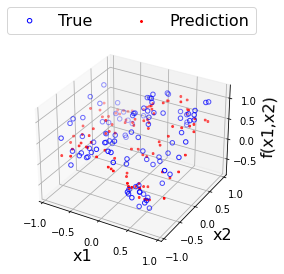

In [22]:
fig = plt.figure()
ax=plt.axes(projection='3d')
ax.scatter(X[:,0],X[:,1],Y,facecolors='none', edgecolors='b', label='True')
ax.scatter(X[:,0],X[:,1],pred_train, color='red',marker="x",s=4,label='Prediction')
ax.set_xlabel('x1',fontsize=16)
ax.set_ylabel('x2',fontsize=16)
ax.set_zlabel('f(x1,x2)',fontsize=16)
plt.legend(loc='upper center',bbox_to_anchor=(0.5,1.18),ncol=2,fontsize=16)
plt.savefig('2_non_square_train.png')
plt.show()

In [23]:
train_diff=np.abs(Y-pred_train)

In [24]:
np.max(train_diff)

tensor(0.65528395, requires_grad=True)

In [25]:
np.min(train_diff)

tensor(0.00524753, requires_grad=True)

In [26]:
np.mean(train_diff)

tensor(0.23605663, requires_grad=True)

## Test error

In [27]:
test1,test2=np.meshgrid(np.linspace(-0.95,0.95,100),np.linspace(-0.95,0.95,100))
test1_flatten=test1.flatten()
test2_flatten=test2.flatten()
X_test=np.concatenate((test1_flatten.reshape(-1,1), test2_flatten.reshape(-1,1)), axis=1)
Y_test=my_objective(X_test)
print(X_test.shape)
print(Y_test.shape)
pred_test=[classical_quantum_net(theta,w,x) for x in zip(test1_flatten,test2_flatten)]

(10000, 2)
(10000,)


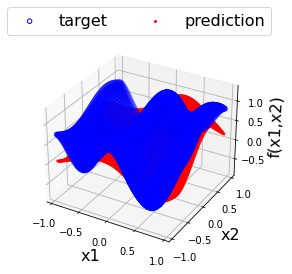

In [28]:
fig=plt.figure()
ax=plt.axes(projection='3d')
ax.scatter(X_test[:,0],X_test[:,1],Y_test,facecolors='none', edgecolors='b',label='target')
ax.scatter(X_test[:,0],X_test[:,1],pred_test,color='red',marker="x",s=4,label='prediction')
ax.set_xlabel('x1',fontsize=16)
ax.set_ylabel('x2',fontsize=16)
ax.set_zlabel('f(x1,x2)',fontsize=16)
plt.legend(loc='upper center',bbox_to_anchor=(0.5,1.18),ncol=2,fontsize=16)
plt.savefig('2_non_square_test.png')
plt.show()

In [29]:
test_diff=np.abs(Y_test-pred_test)

In [30]:
np.max(test_diff)

tensor(0.68528889, requires_grad=True)

In [31]:
np.min(test_diff)

tensor(1.48536412e-05, requires_grad=True)

In [32]:
np.mean(test_diff)

tensor(0.25364218, requires_grad=True)